In [1]:
import sys
sys.path.insert(1, "../TransformerLens/")


from transformer_lens.HookedViT import HookedViT
from transformer_lens.HookedViTConfig import HookedViTConfig
from transformer_lens.loading_from_pretrained import convert_vit_weights, convert_clip_weights
from transformers import AutoProcessor, AutoImageProcessor, ViTForImageClassification, CLIPProcessor, CLIPVisionModelWithProjection, ViTConfig
from transformers import logging
logging.set_verbosity_error()

import torch
torch.set_grad_enabled(False)

from PIL import Image, ImageDraw
import numpy as np
import pickle
import requests
import glob
import circuitsvis as cv
import plotly.io as pio
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
mpl.rcParams['figure.dpi'] = 100

pio.renderers.default = "notebook_connected"

from IPython import get_ipython
ip = get_ipython()
if not ip.extension_manager.loaded:
    ip.extension_manager.load('autoreload')
    %autoreload 2

In [2]:
class Model:
    '''Wrapper class for model + image_processor'''
    def __init__(self, model, image_processor):
        self.model = model
        self.image_processor = image_processor
        
    def __call__(self, im):
        im = self.preprocess(im)
        return self.model(im)
    
    def preprocess(self, im):
        if str(type(self.image_processor)) == "<class 'transformers.models.clip.processing_clip.CLIPProcessor'>":
            im = self.image_processor(images=im, return_tensors='pt')["pixel_values"].to("mps")
        else:
            im = self.image_processor(im, return_tensors='pt')["pixel_values"].to("mps")
            
        return im

def load_model(pretrain="scratch", patch_size=32):
    '''
    :param pretrain: "scratch", "imagenet", "clip"
    :param patch_size: 16, 32
    '''
    if pretrain == "scratch" or pretrain == "imagenet":
        hf_model = ViTForImageClassification.from_pretrained(f"google/vit-base-patch{patch_size}-224-in21k", num_labels=2).to("mps")
        tl_model = HookedViT.from_pretrained(f"google/vit-base-patch{patch_size}-224-in21k")
        image_processor = AutoImageProcessor.from_pretrained(f"google/vit-base-patch{patch_size}-224-in21k")

    elif pretrain == "clip":
        hf_model = CLIPVisionModelWithProjection.from_pretrained(f"openai/clip-vit-base-patch{patch_size}")
        tl_model = HookedViT.from_pretrained(f"openai/clip-vit-base-patch{patch_size}", is_clip=True)
        image_processor = AutoProcessor.from_pretrained(f"openai/clip-vit-base-patch{patch_size}")
        
        '''
        in_features = hf_model.visual_projection.in_features
        hf_model.visual_projection = torch.nn.Linear(in_features, 2)
        tl_model.classifier_head.W = hf_model.visual_projection.weight
        '''
    
    '''
    model_path = glob.glob(f"models/{pretrain}_vit{patch_size}/*.pth")[0]
    model_file = torch.load(model_path, map_location=torch.device("mps"))
    
    if pretrain == "clip":
        model_file["vision_model.embeddings.position_ids"] = hf_model.vision_model.embeddings.position_ids

    hf_model.load_state_dict(model_file)
    
    if pretrain == "clip":
        state_dict = convert_clip_weights(hf_model, tl_model.cfg)
    else:
        state_dict = convert_vit_weights(hf_model, tl_model.cfg)
    tl_model.load_state_dict(state_dict, strict=False)
    '''
    
    model = Model(tl_model.to("mps"), image_processor)
    return model

def imshow(im, white_grid=False, black_grid=False, red_grid=False, grid_size=16, numbers=True):
    if white_grid or black_grid or red_grid:
        if numbers:
            num_str = "num"
        else:
            num_str = ""
            
        grid_im = Image.open(f"stimuli/grid{32}{num_str}.png")
        grid_data = grid_im.getdata()
        
        new_data = []
        for item in grid_data:
            if item[0] < 100 and item[1] < 100 and item[2] < 100:
                new_data.append((0, 0, 0, 0))
            else:
                if white_grid:
                    new_data.append(item)
                elif red_grid:
                    new_data.append((255, 0, 0, 255))
                else:
                    new_data.append((0, 0, 0, 255))
                
        grid_im.putdata(new_data)
        
        bg = im.copy()
        bg.paste(grid_im, (0, 0), grid_im)
        
        plt.imshow(bg) 
        plt.tick_params(
                axis='both',          
                which='both',      
                bottom=False,      
                top=False, 
                left=False,
                labelbottom=False,
                labelleft=False)
    else:
        plt.imshow(im) 
        plt.tick_params(
                axis='both',          
                which='both',      
                bottom=False,      
                top=False, 
                left=False,
                labelbottom=False,
                labelleft=False)

In [3]:
model = load_model(pretrain="clip", patch_size=32)

If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer
Moving model to device:  mps


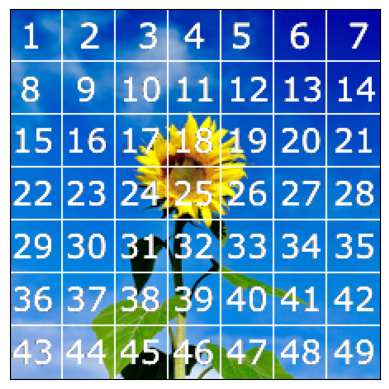

In [4]:
url = "https://hips.hearstapps.com/hmg-prod/images/how-to-grow-sunflowers-1611933753.jpg?fill=1:1&resize=1200:*"
im = Image.open(requests.get(url, stream=True).raw).resize((224, 224)).convert("RGB")
imshow(im, white_grid=True, grid_size=32)
im = model.preprocess(im)

In [28]:
logits, cache = model.model.run_with_cache(im, remove_batch_dim=True)
attention_pattern = cache["pattern", 9, "attn"]
tokens = [str(i) for i in range(1, attention_pattern.shape[1])]
tokens = ["CLS"] + tokens
cv.attention.attention_patterns(tokens=tokens, attention=attention_pattern)

# Notes on heads

- **0-H0**: all tokens attend to CLS. Nothing else is really happening.
- **0-H1**: perhaps a yellow detector? Tokens containing yellow or light green attend to themselves; meanwhile, all other tokens attend to CLS; the tokens attending to themselves attend less strongly to CLS.
- **0-H2**: seems to possibly be copying the middle of the image in a gaussian kernel sort of way to CLS? The very middle token (25) has the strongest attention to CLS, while tokens in a square around it have noticeable but somewhat weaker attention; it could also be attending to the sunflower object, since the attention appears to sort of fan out around the bottom of the image. Maybe it is an object centroid detector? The middle token in this image coincides with the center of the sunflower.
- **0-H3**: as in 0-H2, the very center token attends the most strongly to CLS (however all tokens attend to CLS). 
- **0-H4**: appears to mirror 0-H1 (the possible yellow detector) although with somewhat more emphasis on green parts rather than yellow parts.
- **0-H5**: similar behavior to 0-H1 & 0-H4. These could also possibly be edge detectors...
- **0-H6**: appears to be a background detector. Tokens consisting of the background attend to CLS, while tokens consisting of the foreground (object) do not.
- **0-H7**: appears to be a foreground or object detector, albeit somewhat weaker than 0-H8 (tokens with only a little bit of object are not detected; attention is somewhat weaker). Tokens containing the object/foreground attend to CLS.
- **0-H8**: appears to be a foreground or object detector. Tokens containing the object/foreground attend to CLS. Also some behavior that looks sort of like convolution.
- **0-H9**: similar to 0-H1, 0-H4, & 0-H5.
- **0-H10**: similar to 0-H7 & 0-H8.
- **0-H11**: similar to 0-H0 except there is some weak self-attention for tokens containing the object.

- - -

- **7-H8**: seems to pretty clearly be a background detector. All background (non-object) tokens attend to CLS.
- **8-H1**: appears to be another background detector like 7-H8.
- **8-H6**: appears to be another background detector like 7-H8.
- **9-H1**: appears to be some sort of object detector, except only a few specific tokens are receiving information from the object tokens. For example, tokens 31 and 47 are strongly attended to by the other tokens containing objects, but all other object tokens are only weakly attendended to by other object tokens. The model is storing information in these two tokens for some reason.
- **9-H6**: in the flower and the mushroom image, this head attends to the flower head and the mushroom cap respectively; i.e. the tokens containing these objects attend to each other.
- **9-H7**: appears to be attending to the head of the flower. Tokens containing the head of the flower attend to each other, although token 18 receives the strongest attention.
- **9-H10**: this seems to be representing both parts of the flower: the head and the stem, but separately. The tokens containing the flower head attend to each other, while the tokens containing the flower stem attend to each other.

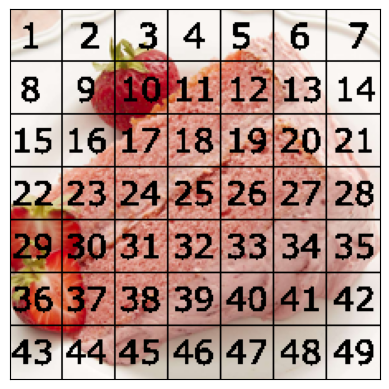

In [9]:
url = "https://www.allrecipes.com/thmb/Huh-I63aYc_zZ0NbLECEpFD0BcI=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/60564-StrawberryCakeFromScratch-ddfms-4X3-0291-1-cd8254e28ea14112b5fc49e25cd08ff6.jpg"
im = Image.open(requests.get(url, stream=True).raw)

width, height = im.size 
new_width = min([width, height])
new_height = min([width, height])
left = (width - new_width)/2
top = (height - new_height)/2
right = (width + new_width)/2
bottom = (height + new_height)/2
im = im.crop((left, top, right, bottom)).resize((224, 224)).convert("RGB")

imshow(im, black_grid=True, grid_size=32)
im = model.preprocess(im)

In [11]:
logits, cache = model.model.run_with_cache(im, remove_batch_dim=True)
attention_pattern = cache["pattern", 9, "attn"]
tokens = [str(i) for i in range(1, attention_pattern.shape[1])]
tokens = ["CLS"] + tokens
cv.attention.attention_patterns(tokens=tokens, attention=attention_pattern)

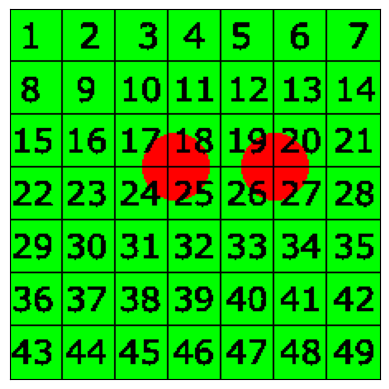

In [39]:
test_im = Image.new(mode="RGB", size=(224, 224), color=(0, 255, 0))
'''
mat = np.tril(np.ones((224, 224)))

for i in range(224):
    for j in range(224):
        if mat[i, j] == 1:
            test_im.putpixel((i, j), (0, 0, 255))
'''
draw = ImageDraw.Draw(test_im)
#draw.ellipse((0, 0, 50, 50), fill=(255, 255, 255), outline=(0, 255, 255))
#draw.ellipse((60, 60, 180, 180), fill=(0, 0, 255), outline=(0, 0, 255))

draw.ellipse((140, 75, 180, 115), fill=(255, 0, 0), outline=(255, 0, 0))
draw.ellipse((80, 75, 120, 115), fill=(255, 0, 0), outline=(255, 0, 0))
#draw.ellipse((100, 100, 140, 140), fill=(255, 0, 0), outline=(255, 0, 0))

#patch = test_im.crop(box=(64, 64, 96, 96)).rotate(180)
#test_im.paste(patch, box=(64, 64))

imshow(test_im, black_grid=True)
test_im = model.preprocess(test_im)

In [40]:
logits, cache = model.model.run_with_cache(test_im, remove_batch_dim=True)
attention_pattern = cache["pattern", 2, "attn"]
tokens = [str(i) for i in range(1, attention_pattern.shape[1])]
tokens = ["CLS"] + tokens
cv.attention.attention_patterns(tokens=tokens, attention=attention_pattern)

- **2-H3**: continuity (right to left)?
- **2-H6**: the white and red spheres are attending to themselves (but not each other). This is also the case when both objects are red.
- **2-H9**: continuity (bottom to top)?

In [43]:
idx = 6  # which attention head

head = attention_pattern[idx, :, :].squeeze(0)  # head dim, source, dest
obj1_tokens = [17, 18, 24, 25]
#obj2_tokens = [20, 21, 27, 28]
#obj2_tokens = [19, 20, 26, 27]
obj2_tokens = [18, 19, 25, 26]
obj1_pairs = list(itertools.product(obj1_tokens, repeat=2))
obj2_pairs = list(itertools.product(obj2_tokens, repeat=2))
obj_obj_pairs = list(itertools.product(set(obj1_tokens + obj2_tokens), repeat=2))

obj1_attn = 0
obj2_attn = 0
obj_obj_attn = 0
#bg_attn = 0
all_attn = 0

for i in range(1, 50):
    for j in range(1, 50):
        if (i, j) in obj1_pairs:
            obj1_attn += head[i, j]
        elif (i, j) in obj2_pairs:
            obj2_attn += head[i, j]
        elif (i, j) in obj_obj_pairs:
            obj_obj_attn += head[i, j]

        '''
        else:
            bg_attn += head[i, j]
        '''
        all_attn += head[i, j]

obj1_attn /= len(obj1_pairs)
obj2_attn /= len(obj2_pairs)
obj_obj_attn /= len(obj_obj_pairs)
#bg_attn /= (49*48) - len(set(obj1_pairs + obj2_pairs + obj_obj_pairs))
all_attn /= 49*49

print(obj1_attn / all_attn)
print(obj2_attn / all_attn)
print(obj_obj_attn)
print(all_attn)

#print(obj_attn / (bg_attn + obj_attn))
#print(obj1_attn / (bg_attn + obj1_attn))
#print(obj2_attn / (bg_attn + obj2_attn))
#print(obj_obj_attn / (bg_attn + obj_obj_attn))

tensor(5.0171, device='mps:0')
tensor(3.2278, device='mps:0')
tensor(0.0110, device='mps:0')
tensor(0.0139, device='mps:0')


tensor(7.4889, device='mps:0')